<a href="https://colab.research.google.com/github/Hacxmr/NLP_Project/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Text Summarization with Bias Detection in News

In [2]:
!pip install requests beautifulsoup4 pandas tqdm selenium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.14.0
    Uninstalling typing_extensions-4.14.0:
      Successfully uninstalled typing_extensions-4.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
typeguard 4.4.3 requires typing_extensions>=4.14.0, but you have typing-extensions 4.13.2 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_mach

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

text = "Instead of promised 'acche din', days of debt have arrived: Congress's dig at Modi Government"
summary = summarizer(text, max_length=20, min_length=5, do_sample=False)


Device set to use cpu


In [ ]:
print(summary)

[{'summary_text': "Instead of promised 'acche din', days of debt have arrived: Congress's dig"}]


In [ ]:
summary = summarizer(text, max_length=30, min_length=5, do_sample=False)
print(summary[0]['summary_text'])


Your max_length is set to 30, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Instead of promised 'acche din', days of debt have arrived: Congress's dig at Modi.


##Sentiment Analysis

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")
sentiment = sentiment_pipeline(summary[0]['summary_text'])
print(sentiment)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[{'label': 'NEGATIVE', 'score': 0.9930257797241211}]


##3. Explore BART/T5 Models

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization", model="t5-base",tokenizer="t5-base")


input_text = "summarize: "+text
summary = summarizer(input_text, max_length=20, min_length=5, do_sample=False)
print(summary[0]['summary_text'])

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


instead of promised 'acche din', days of debt have arrived .


##Data Collection - Scraping

In [3]:
!pip install requests beautifulsoup4 pandas transformers


In [4]:
!pip install selenium pandas transformers beautifulsoup4


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import tempfile

options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument(f"--user-data-dir={tempfile.mkdtemp()}")  # fix for profile conflict

driver = webdriver.Chrome(options=options)


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from urllib.parse import urljoin
from transformers import pipeline

# NLP Pipelines
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
sentiment_analyzer = pipeline("sentiment-analysis")
bias_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Constants
BASE_URL = "https://www.indiatoday.in/elections"
HEADERS = {"User-Agent": "Mozilla/5.0"}
KEYWORDS = [
    "delhi election", "delhi polls", "aap", "kejriwal", "delhi mla",
    "bihar election", "bihar polls", "tejashwi", "nitish", "bjp", "rjd", "jdu",
    "lok sabha", "2024", "campaign", "manifesto", "seat sharing", "voting"
]
MAX_ARTICLES = 15

def is_delhi_election(text):
    return any(k in text.lower() for k in KEYWORDS)

def get_article_links():
    r = requests.get(BASE_URL, headers=HEADERS)
    soup = BeautifulSoup(r.text, "html.parser")

    links = []
    for a in soup.find_all("a", href=True, title=True):
        href = urljoin(BASE_URL, a["href"])
        title = a["title"].strip()
        if is_delhi_election(title):
            links.append((href, title))
    return list(set(links))

def extract_article_content(url):
    try:
        r = requests.get(url, headers=HEADERS)
        soup = BeautifulSoup(r.text, "html.parser")
        paragraphs = soup.find_all("p")
        content = " ".join(p.get_text(strip=True) for p in paragraphs if len(p.text.strip()) > 30)
        return content
    except Exception as e:
        print(f"[-] Error scraping {url}: {e}")
        return ""

def summarize_sentiment_bias(text):
    summary = summarizer(text[:1024])[0]['summary_text']
    sentiment = sentiment_analyzer(summary)[0]
    bias = bias_classifier(summary, candidate_labels=["pro-government", "anti-government", "neutral"])
    return summary, sentiment["label"], sentiment["score"], bias["labels"][0], bias["scores"][0]

def main():
    articles = get_article_links()
    print(f"[+] Found {len(articles)} Delhi election-related articles")

    data = []
    for i, (url, title) in enumerate(articles[:MAX_ARTICLES]):
        print(f"[{i+1}] Scraping: {title}")
        content = extract_article_content(url)
        if content:
            summary, sentiment, senti_score, bias, bias_score = summarize_sentiment_bias(content)
            data.append({
                "title": title,
                "url": url,
                "content": content,
                "summary": summary,
                "sentiment": sentiment,
                "sentiment_score": round(senti_score, 2),
                "bias": bias,
                "bias_score": round(bias_score, 2),
                "source": "India Today"
            })
        time.sleep(random.uniform(1, 2.5))

    df = pd.DataFrame(data)
    df.to_csv("indiatoday_elections.csv", index=False)
    print(f"[✓] Saved {len(df)} articles to indiatoday_delhi_elections.csv")

if __name__ == "__main__":
    main()


Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu


[+] Found 37 Delhi election-related articles
[1] Scraping: BJP's Mohan Singh Bisht proposes to rename Mustafabad to Shivpuri
[2] Scraping: Chose wrong path, focused on liquor: Anna Hazare on Arvind Kejriwal's poll loss
[3] Scraping: Amanatullah Khan slams Rahul Gandhi for campaigning in Okhla to 'defeat' AAP
[4] Scraping: BJP top brass holds hectic parleys to finalise Delhi's next Chief Minister
[5] Scraping: Down but not out: Is Nitish Kumar still the X-factor in Bihar Politics?
[6] Scraping: Nitish Kumar changes party for kursi: Congress targets BJP-JDU alliance
[7] Scraping: BJP seeks dominance in Delhi civic body following Assembly success
[8] Scraping: RJD leader pitches Tejashwi Yadav as chief ministerial face ahead of meet today
[9] Scraping: Is Kanhaiya Kumar stealing Tejashwi Yadav's thunder on jobs, migration in Bihar?
[10] Scraping: BJP considers candidates for Delhi Chief Minister's post after win
[11] Scraping: BJP to release multiple CAG reports in upcoming Delhi assembly

##NDTV - SCRAPING AND ANALYSIS

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import tempfile
from transformers import pipeline

# NLP Pipelines
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
sentiment_analyzer = pipeline("sentiment-analysis")
bias_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Focus keywords for Delhi and Bihar elections
KEYWORDS = [
    "delhi election", "delhi polls", "aap", "kejriwal", "delhi mla",
    "bihar election", "bihar polls", "tejashwi", "nitish", "bjp", "rjd", "jdu",
    "lok sabha", "2024", "campaign", "manifesto", "seat sharing", "voting"
]

# Selenium Setup
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument(f"--user-data-dir={tempfile.mkdtemp()}")
driver = webdriver.Chrome(options=options)

def is_target_region(text):
    return any(keyword in text.lower() for keyword in KEYWORDS)

def get_articles():
    url = "https://www.ndtv.com/elections"
    print(f"[+] Visiting: {url}")
    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    links = []

    for tag in soup.find_all("a", class_="crd_lnk", href=True):
        title = tag.get_text(strip=True)
        href = tag["href"]
        if title and is_target_region(title):
            links.append((title, href))

    return list(set(links))

def extract_article_content(url):
    try:
        driver.get(url)
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, "html.parser")
        paragraphs = soup.find_all("p")
        content = " ".join(p.get_text(strip=True) for p in paragraphs if len(p.text.strip()) > 30)
        return content
    except Exception as e:
        print(f"[-] Error scraping {url}: {e}")
        return ""

def analyze_text(text):
    try:
        summary = summarizer(text[:1024])[0]["summary_text"]
        sentiment_result = sentiment_analyzer(summary)[0]
        sentiment = sentiment_result["label"]
        sentiment_score = round(sentiment_result["score"], 2)

        bias_result = bias_classifier(summary, candidate_labels=["pro-government", "anti-government", "neutral"])
        bias = bias_result["labels"][0]
        bias_score = round(bias_result["scores"][0], 2)

        return summary, sentiment, sentiment_score, bias, bias_score
    except Exception as e:
        print(f"[-] NLP error: {e}")
        return "Summary failed", "UNKNOWN", 0.0, "UNKNOWN", 0.0

def main():
    articles = get_articles()
    print(f"[+] Found {len(articles)} Delhi/Bihar election-related articles")

    data = []
    for i, (title, url) in enumerate(articles[:15]):
        print(f"[{i+1}] Scraping: {title}")
        content = extract_article_content(url)
        if content:
            summary, sentiment, senti_score, bias, bias_score = analyze_text(content)
            data.append({
                "title": title,
                "url": url,
                "content": content,
                "summary": summary,
                "sentiment": sentiment,
                "sentiment_score": senti_score,
                "bias": bias,
                "bias_score": bias_score,
                "source": "NDTV"
            })
        time.sleep(random.uniform(1.5, 2.5))

    df = pd.DataFrame(data)
    df.to_csv("ndtv_delhi_bihar_election.csv", index=False)
    print(f"[✓] Saved {len(df)} articles to ndtv_delhi_bihar_election.csv")

if __name__ == "__main__":
    main()
    driver.quit()


Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Device set to use cpu


[+] Visiting: https://www.ndtv.com/elections
[+] Found 15 Delhi/Bihar election-related articles
[1] Scraping: "Governance Is Not Theatrics": PM's Dig At AAP After BJP Wins Delhi
[2] Scraping: Delhi Oath Ceremony On Thursday, BJP Yet To Name Chief Minister
[3] Scraping: "AAP Was Finished When...": Ex Leader Ashutosh's Post After Delhi Drubbing
[4] Scraping: Video: AAP's Office Doors Shut As Arvind Kejriwal, Manish Sisodia Lose Delhi
[5] Scraping: "Was Doing Good Job, But...": Anna Hazare On Arvind Kejriwal's Poll Defeat
[6] Scraping: "2026MeinBengalKi Baari": Mamata Banerjee Warned After BJP's Delhi Win
[7] Scraping: AAP's Saurabh Bharadwaj Turns YouTuber After Delhi Election Loss
[8] Scraping: "Rule Of Lies Has Ended": Amit Shah On BJP's Delhi Victory
[9] Scraping: AAP To Replace Chief Minister In Punjab? What Bhagwant Mann Said
[10] Scraping: How AAP-Congress Feud Split Opposition Votes
[11] Scraping: AAP vs Congress In Punjab Over '30 MLAs In Touch With Us' Claim
[12] Scraping: Congr

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import tempfile
from transformers import pipeline
import signal
import sys

# Load NLP models
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
sentiment_analyzer = pipeline("sentiment-analysis")

# Bias classifier
def classify_bias(text):
    text = text.lower()
    pro_gov = any(word in text for word in ["modi", "bjp", "nda", "development"])
    anti_gov = any(word in text for word in ["scam", "failure", "protest", "resign", "criticism", "controversy"])
    if pro_gov and not anti_gov:
        return "PRO-GOVERNMENT"
    elif anti_gov and not pro_gov:
        return "ANTI-GOVERNMENT"
    elif pro_gov and anti_gov:
        return "MIXED"
    return "NEUTRAL"

# Keywords to filter articles
KEYWORDS = ["delhi election", "bihar election", "2024", "lok sabha", "nda", "india bloc", "upa", "bjp", "congress"]

# Setup Selenium
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument(f"--user-data-dir={tempfile.mkdtemp()}")
driver = webdriver.Chrome(options=options)

# Ensure driver quits on script interruption
def quit_driver(*args):
    driver.quit()
    sys.exit(0)

signal.signal(signal.SIGINT, quit_driver)
signal.signal(signal.SIGTERM, quit_driver)

# Step 1: Collect article links from TOI election pages
def get_toi_articles():
    base_urls = [
        "https://timesofindia.indiatimes.com/elections/assembly-elections/delhi",
        "https://timesofindia.indiatimes.com/elections/assembly-elections/bihar"
    ]
    articles = []

    for url in base_urls:
        driver.get(url)
        time.sleep(3)
        soup = BeautifulSoup(driver.page_source, "html.parser")
        links = soup.find_all("a", href=True)
        for tag in links:
            title = tag.get_text(strip=True)
            link = tag["href"]
            if title and any(k in title.lower() for k in KEYWORDS):
                if not link.startswith("http"):
                    link = "https://timesofindia.indiatimes.com" + link
                articles.append((title, link))
            if len(articles) >= 15:
                return articles
    return articles

# Step 2: Extract article content
def extract_article(url):
    try:
        driver.get(url)
        time.sleep(2)
        soup = BeautifulSoup(driver.page_source, "html.parser")
        article_blocks = soup.find_all("div", class_="Normal")
        if not article_blocks:
            article_blocks = soup.find_all("p")
        content = " ".join(p.get_text(strip=True) for p in article_blocks if len(p.text.strip()) > 30)
        return content.strip()
    except Exception as e:
        print(f"[-] Error extracting article from {url}: {e}")
        return ""

# Step 3: Main pipeline
def main():
    print("[+] Scraping TOI for Delhi & Bihar election news...")
    articles = get_toi_articles()
    print(f"[+] Found {len(articles)} relevant articles")

    records = []
    for i, (title, url) in enumerate(articles):
        print(f"[{i+1}] {title}")
        content = extract_article(url)
        if content:
            try:
                trimmed_content = content[:1024 * 4]  # Conservative length estimate for token limit
                summary = summarizer(trimmed_content)[0]['summary_text']
                sentiment_result = sentiment_analyzer(summary)[0]
                sentiment = sentiment_result['label']
                score = round(sentiment_result['score'], 2)
                bias = classify_bias(summary)

                records.append({
                    "title": title,
                    "url": url,
                    "summary": summary,
                    "sentiment": sentiment,
                    "confidence": score,
                    "bias": bias,
                    "content": content,
                    "source": "TOI"
                })

            except Exception as e:
                print(f"[-] Failed NLP processing for: {url} | Error: {e}")
        else:
            print(f"[-] Skipping empty content: {url}")
        time.sleep(random.uniform(1.5, 2.5))

    # Save data
    df = pd.DataFrame(records)
    df.to_csv("toi_delhi_bihar_elections.csv", index=False)
    print("[✓] Data saved to toi_delhi_bihar_elections.csv")

# Run
if __name__ == "__main__":
    try:
        main()
    finally:
        driver.quit()


Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[+] Scraping TOI for Delhi & Bihar election news...
[+] Found 15 relevant articles
[1] Delhi Elections


Your max_length is set to 142, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


[2] Lok Sabha 2024
[3] DELHI ELECTIONS


Your max_length is set to 142, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


[4] Congress Candidates List
[5] BJP Candidate List
[6] Delhi Election 2025
[7] NewsFeb 9, 2025What win in Delhi polls for 11 councillors means for MCDOf 22 councillors in the Delhi assembly elections, 11 won with BJP securing eight seats and AAP three. BJP now has 112 councillors and AAP 119. The MCD has 12 vacant positions, impacting mayoral election dynamics. BJP may gain an advantage due to additional support from MPs and MLAs, despite past tight race margins.
[-] Skipping empty content: https://timesofindia.indiatimes.com/elections/assembly-elections/delhi/news/what-win-for-11-councillors-means-for-mcd/articleshow/118102373.cms
[8] NewsFeb 9, 2025'All dreams of my father will be fulfilled': BJP's Parvesh Verma pays tribute to former Delhi CM Sahib Singh Verma
[9] NewsFeb 9, 2025After big Delhi win, BJP's Parvesh Verma pays tribute to father, vows to fulfil his ‘unfinished works’
[10] NewsFeb 9, 2025'Shameless': Rajya Sabha MP Swati Maliwal on Atishi's dance video after her poll wi

Your max_length is set to 142, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


[11] 'Memories of 1993 have refreshed': BJP's Parvesh Verma who took New Delhi from AAP's Arvind Kejriwal


Your max_length is set to 142, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


[12] Delhi election results 2025: Winners and losers
[13] Delhi Elections
[14] Delhi Election Result 2025
[15] Delhi Elections
[✓] Data saved to toi_delhi_bihar_elections.csv


In [ ]:
!pip install selenium pandas beautifulsoup4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.14.0
    Uninstalling typing_extensions-4.14.0:
      Successfully uninstalled typing_extensions-4.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
typeguard 4.4.3 requires typing_extensions>=4.14.0, but you have typing-extensions 4.13.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and pla

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from transformers import pipeline

# NLP pipelines
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
sentiment_analyzer = pipeline("sentiment-analysis")

# Bias detection (basic rule-based)
def detect_bias(text):
    t = text.lower()
    if any(k in t for k in ["bjp", "modi", "development"]):
        return "Pro-Government"
    if any(k in t for k in ["aam aadmi", "congress", "rjd", "opposition"]):
        return "Anti-Government"
    return "Neutral"

# Keywords for relevance
KEYWORDS = ["delhi", "bihar", "election", "assembly", "mla", "poll", "campaign"]

# Multiple sources from The Hindu
START_URLS = [
    "https://www.thehindu.com/elections/",
    "https://www.thehindu.com/elections/delhi-assembly/",
    "https://www.thehindu.com/elections/bihar-assembly/"
]

def is_relevant(text):
    return any(k in text.lower() for k in KEYWORDS)

def fetch_article_links():
    all_links = []
    seen = set()
    for url in START_URLS:
        print(f"[+] Scanning: {url}")
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(r.text, "html.parser")
        for div in soup.select("div.right-content"):
            h3 = div.find("h3", class_="title")
            if h3 and h3.a:
                title = h3.a.get_text(strip=True)
                href = h3.a["href"]
                if href not in seen and is_relevant(title):
                    all_links.append((title, href))
                    seen.add(href)
        for a in soup.find_all("a", href=True):
            title = a.get_text(strip=True)
            href = a["href"]
            if href.startswith("https://www.thehindu.com") and href not in seen and is_relevant(title):
                all_links.append((title, href))
                seen.add(href)
    return all_links

def extract_content(url):
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(r.text, "html.parser")
        paras = soup.select("div.ece-1705723324092 p") or soup.find_all("p")
        return " ".join(p.get_text(strip=True) for p in paras if len(p.get_text(strip=True)) > 30)
    except:
        return ""

def analyze(text):
    try:
        summary = summarizer(text[:1024])[0]['summary_text']
        sent = sentiment_analyzer(summary)[0]
        bias = detect_bias(summary)
        return summary, sent['label'], round(sent['score'], 2), bias
    except:
        return "Summary failed", "UNKNOWN", 0.0, "Neutral"

def main():
    articles = fetch_article_links()
    print(f"[+] Found {len(articles)} total relevant articles from The Hindu")
    data = []
    for title, url in articles[:15]:
        print(f"🗂️  {title}")
        content = extract_content(url)
        if content:
            summary, sentiment, sent_score, bias = analyze(content)
            data.append({
                "title": title,
                "url": url,
                "summary": summary,
                "sentiment": sentiment,
                "sent_score": sent_score,
                "bias": bias,
                "source": "The Hindu"
            })
        time.sleep(random.uniform(1.5, 2.5))
    df = pd.DataFrame(data)
    df.to_csv("thehindu_elections_delhi_bihar.csv", index=False)
    print(f"[✓] Saved {len(data)} articles to thehindu_elections_delhi_bihar.csv")

if __name__ == "__main__":
    main()


Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[+] Scanning: https://www.thehindu.com/elections/
[+] Scanning: https://www.thehindu.com/elections/delhi-assembly/
[+] Scanning: https://www.thehindu.com/elections/bihar-assembly/
[+] Found 54 total relevant articles from The Hindu
🗂️  BJP’s USP in Delhi: Micro-level outreach programmes, door-to-door campaigns
🗂️  BJP urges Delhi L-G to restore ‘Sheesh Mahal’ to original state
🗂️  L-G’s actions, excise probe, AAP-da led to AAP’s election setback
🗂️  We failed to get anti-BJP votes of Dalits, minorities: Delhi Congress chief
🗂️  Bihar
🗂️  Delhi
🗂️  Elections
🗂️  Delhi Assembly
🗂️  Days after Delhi defeat, Kejriwal to meet CM Mann, Punjab AAP MLAs on February 11
🗂️  BJP begins talks to select Delhi CM; oath-taking likely after PM’s U.S. visit
🗂️  AAP’s defeat in Delhi election lifts the Congress’s spirits in Punjab
🗂️  Watch: Delhi Assembly Elections 2025 Round Up | Major upset for AAP as BJP seals victory
🗂️  Delhi election result: Kejriwal, Atishi meet newly elected AAP MLAs, ask them 

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from transformers import pipeline

# NLP pipelines
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
sentiment_analyzer = pipeline("sentiment-analysis")

# Bias detection (rule-based)
def detect_bias(text):
    t = text.lower()
    if any(k in t for k in ["bjp", "modi", "development"]):
        return "Pro-Government"
    if any(k in t for k in ["aam aadmi", "congress", "rjd", "opposition"]):
        return "Anti-Government"
    return "Neutral"

# Relevant keywords
KEYWORDS = ["delhi", "bihar", "election", "assembly", "mla", "poll", "campaign"]

# URLs to scan
START_URLS = [
    "https://www.thehindu.com/elections/",
    "https://www.thehindu.com/elections/delhi-assembly/",
    "https://www.thehindu.com/elections/bihar-assembly/"
]

def is_relevant(text):
    return any(k in text.lower() for k in KEYWORDS)

# Step 1: Collect article links
def fetch_article_links():
    all_links = []
    seen = set()
    for url in START_URLS:
        print(f"[+] Scanning: {url}")
        try:
            r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
            soup = BeautifulSoup(r.text, "html.parser")

            # Structured blocks
            for div in soup.select("div.right-content"):
                h3 = div.find("h3", class_="title")
                if h3 and h3.a:
                    title = h3.a.get_text(strip=True)
                    href = h3.a["href"]
                    if href not in seen and is_relevant(title):
                        all_links.append((title, href))
                        seen.add(href)

            # Fallback: general <a> links
            for a in soup.find_all("a", href=True):
                title = a.get_text(strip=True)
                href = a["href"]
                if href.startswith("https://www.thehindu.com") and href not in seen and is_relevant(title):
                    all_links.append((title, href))
                    seen.add(href)

        except Exception as e:
            print(f"[-] Error accessing {url}: {e}")

    return all_links

# Step 2: Extract full article content
def extract_content(url):
    try:
        r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(r.text, "html.parser")
        paras = soup.select("div.ece-1705723324092 p") or soup.find_all("p")
        content = " ".join(p.get_text(strip=True) for p in paras if len(p.get_text(strip=True)) > 30)
        return content
    except Exception as e:
        print(f"[-] Failed to extract {url}: {e}")
        return ""

# Step 3: Summarization + Sentiment + Bias
def analyze(text):
    try:
        truncated = text[:1024 * 4]  # Prevent token overflow
        summary = summarizer(truncated)[0]['summary_text']
        sent = sentiment_analyzer(summary)[0]
        bias = detect_bias(summary)
        return summary, sent['label'], round(sent['score'], 2), bias
    except Exception as e:
        print(f"[-] NLP error: {e}")
        return "Summary failed", "UNKNOWN", 0.0, "Neutral"

# Step 4: Main collection function
def main():
    articles = fetch_article_links()
    print(f"[+] Found {len(articles)} total relevant articles from The Hindu")

    data = []
    for i, (title, url) in enumerate(articles[:55]):
        print(f"[{i+1}] 🗂️  {title}")
        content = extract_content(url)
        if content:
            summary, sentiment, sent_score, bias = analyze(content)
            data.append({
                "title": title,
                "url": url,
                "summary": summary,
                "sentiment": sentiment,
                "sent_score": sent_score,
                "bias": bias,
                "source": "The Hindu"
            })
        else:
            print(f"[-] Skipped due to empty content.")
        time.sleep(random.uniform(1.5, 2.5))  # polite scraping

    df = pd.DataFrame(data)
    df.to_csv("thehindu_elections_delhi_bihar.csv", index=False)
    print(f"[✓] Saved {len(data)} articles to thehindu_elections_delhi_bihar.csv")

if __name__ == "__main__":
    main()


Device set to use cpu
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[+] Scanning: https://www.thehindu.com/elections/
[+] Scanning: https://www.thehindu.com/elections/delhi-assembly/
[+] Scanning: https://www.thehindu.com/elections/bihar-assembly/
[+] Found 54 total relevant articles from The Hindu
[1] 🗂️  BJP’s USP in Delhi: Micro-level outreach programmes, door-to-door campaigns
[2] 🗂️  BJP urges Delhi L-G to restore ‘Sheesh Mahal’ to original state
[3] 🗂️  L-G’s actions, excise probe, AAP-da led to AAP’s election setback
[4] 🗂️  We failed to get anti-BJP votes of Dalits, minorities: Delhi Congress chief
[5] 🗂️  Bihar
[6] 🗂️  Delhi
[7] 🗂️  Elections
[8] 🗂️  Delhi Assembly
[9] 🗂️  Days after Delhi defeat, Kejriwal to meet CM Mann, Punjab AAP MLAs on February 11
[10] 🗂️  BJP begins talks to select Delhi CM; oath-taking likely after PM’s U.S. visit
[11] 🗂️  AAP’s defeat in Delhi election lifts the Congress’s spirits in Punjab
[12] 🗂️  Watch: Delhi Assembly Elections 2025 Round Up | Major upset for AAP as BJP seals victory
[13] 🗂️  Delhi election result:

##Merging the files


In [ ]:
import pandas as pd

# Load individual files
files = {
    "TOI": "/content/toi_delhi_bihar_elections.csv",
    "NDTV": "/content/ndtv_delhi_bihar_election.csv",
    "IndiaToday": "/content/indiatoday_elections.csv",
    "TheHindu": "/content/thehindu_elections_delhi_bihar.csv"
}

dataframes = []

for source, path in files.items():
    df = pd.read_csv(path)

    # Normalize column names (some files may differ slightly)
    df.rename(columns={
        "sentiment_score": "confidence",
        "sent_score": "confidence",
        "bias_score": "bias_confidence"
    }, inplace=True)

    # Ensure all expected columns are present
    for col in ["title", "url", "summary", "sentiment", "confidence", "bias", "content", "source"]:
        if col not in df.columns:
            df[col] = None  # Add missing columns with default None

    df["source"] = source  # Add consistent source label
    dataframes.append(df[["title", "url", "summary", "sentiment", "confidence", "bias", "content", "source"]])

# Concatenate all into one DataFrame
merged_df = pd.concat(dataframes, ignore_index=True)

# Save to new file
merged_df.to_csv("merged_election_news_dataset.csv", index=False)

print(f"[✓] Merged {len(merged_df)} total articles into 'merged_election_news_dataset.csv'")


[✓] Merged 98 total articles into 'merged_election_news_dataset.csv'


##Visualize Bias/Sentiment per News Source and State



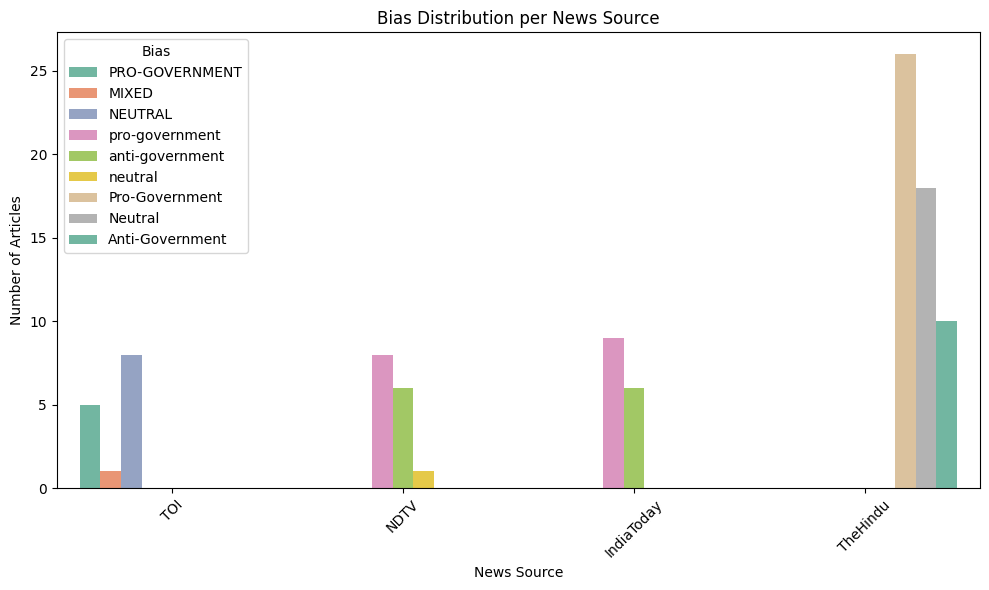

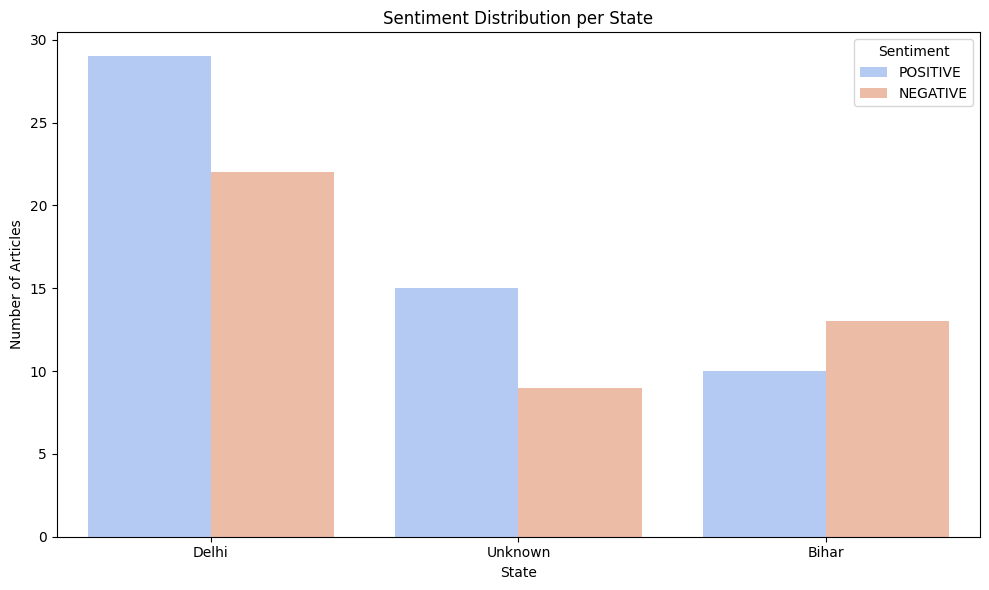

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your merged dataset
df = pd.read_csv("merged_election_news_dataset.csv")

# Clean & process
df.dropna(subset=["summary", "source"], inplace=True)
df["summary_lower"] = df["summary"].str.lower()

# Infer state from summary
def infer_state(text):
    if "delhi" in text:
        return "Delhi"
    elif "bihar" in text:
        return "Bihar"
    return "Unknown"

df["state"] = df["summary_lower"].apply(infer_state)

# Chart 1: Bias distribution per source
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="source", hue="bias", palette="Set2")
plt.title("Bias Distribution per News Source")
plt.xlabel("News Source")
plt.ylabel("Number of Articles")
plt.legend(title="Bias")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Chart 2: Sentiment per state
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="state", hue="sentiment", palette="coolwarm")
plt.title("Sentiment Distribution per State")
plt.xlabel("State")
plt.ylabel("Number of Articles")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils import resample

# Example: Upsample IndiaToday and NDTV
df_balanced = pd.concat([
    resample(df[df["source"] == "IndiaToday"], replace=True, n_samples=10, random_state=42),
    resample(df[df["source"] == "NDTV"], replace=True, n_samples=10, random_state=42),
    df[df["source"] == "TOI"],
    df[df["source"] == "TheHindu"]
])


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=2000)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', min_df=2)


##Train Classifier: Predict News Source from Summary

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Features and labels
X = df["summary"]
y = df["source"]

# Vectorize summaries
vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

  IndiaToday       0.00      0.00      0.00         3
        NDTV       0.00      0.00      0.00         3
         TOI       1.00      0.25      0.40         4
    TheHindu       0.53      1.00      0.69        10

    accuracy                           0.55        20
   macro avg       0.38      0.31      0.27        20
weighted avg       0.46      0.55      0.42        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save processed dataframe
df.to_csv("processed_merged_election_data.csv", index=False)
